# Calorimeter Energy Study

# 0. Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import time
import os

---
# 1. Setup

## 1.1. Load QDC and TDC from Text File

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `ogEventNums`: An array where `ogEventNums[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events

In [2]:
def load_TQDC(finPath):
    # basePath = "/media/sf_data/"
    basePath = r'/media/eris/Sync1/sync/01_Research/MUSE/data'

    # load data from file
    fin = os.path.join(basePath, finPath)
    t0 = time.time()
    raw_data = np.loadtxt(fin, skiprows = 5)
    t1 = time.time()
    print(f"Data file read in {t1-t0:.2f} seconds.")
    # return raw_data

    
    # initialize formatted data array
    num_events = raw_data.shape[0]
    print(f'There are {num_events} events')
    TDC = np.zeros((num_events, 8, 8), dtype=float)
    QDC = np.zeros((num_events, 8, 8), dtype=float)
    ogEventNums = np.zeros((num_events), dtype=int)
    
    
    # format data to [event#][x][y]
    t0 = time.time()
    i_event = -1

    
    for event in raw_data:
        i_event += 1 
        for x in range(8):
            # # this method preserves the original event number, but doesn't work when events aren't one by one
            # TDC [ np.int_(event[0]) ] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            # QDC [ np.int_(event[0]) ] [x] [:] = event[16*x+2 : 16*x+17 : 2]
            
            TDC [i_event] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            QDC [i_event] [x] [:] = event[16*x+2 : 16*x+17 : 2] 
            ogEventNums [i_event] = event[0]
            
    t1 = time.time()
    print(f"Data file formatted to array in {t1-t0:.2f} seconds.")
    
    return TDC, QDC, ogEventNums

In [3]:
# base = r'C:\Users\zk117\Documents\00.local_WL-202\MUSE\data\calorimeter\elog_2341'
base = r'calorimeter/Elog2359/e-pid_bm_cut'


# fin = r'run12130_calo_qdc_tdc_raw.txt' # First 100,000 (out of 1 mil) events, completely raw and unfiltered 
# fin = r'run12130_calo_qdc_tdc_cut.txt' # BH electron PID cut + beam monitor hit cut
fin = r'run12354_calo_qdc_tdc.txt'

raw_data = load_TQDC(os.path.join(base, fin))

Data file read in 0.47 seconds.
There are 45477 events
Data file formatted to array in 0.57 seconds.


## 1.2. Event Display

In [4]:
colormap = 'magma'

def plotEvent(raw_data, event_num):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Plots an 8x8 histogram for the event
    '''
    
    TDC, QDC, ogEventNums = raw_data[:]
    
    ## 1. Plot Setup
    fig, (QAx, TAx) = plt.subplots(nrows=1, ncols=2, figsize= (13,5))#(11,4))
    plt.title(f'QDC for Event #{ogEventNums[event_num]}')

    ## 2. Plot QDC
    
    ## 2.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log10(np.where(QDC[event_num] <= 0, 0.01, QDC[event_num]))
    
    ## 2.2. Set flexible* max value for colorbar (*if the max qdc of this event is greater than the preset value, then use the actual max qdc value)
        # To cancel this effect, just set the preset value to be -1
                                                                                        # Format flexible vmax here
    presetMaxQDC = 3.5                                                                    
    if np.amax(thisFrame) > presetMaxQDC:
        this_vmax = np.amax(thisFrame)
    else:
        this_vmax = presetMaxQDC

    ## 2.3. Plot everything
    
    QPlot = QAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=this_vmax) # make sure to transpose frame for imshow
    
    QAx.set_title(f'QDC for Event #{ogEventNums[event_num]}')
    QAx.invert_yaxis()
    QAx.set_xticks(np.arange(0,8))
    Qcbar = plt.colorbar(QPlot, ax=QAx)
    Qcbar.set_label(r'QDC Counts ($\log_{10}$)', y=0.75)
    QAx.set_xlabel('X-coordinate of Bar')
    QAx.set_ylabel('Y-coordinate of Bar')
    # cbar.ax.tick_params()
   
    ## 2.4. Show QDC values in each square
    for x in range(8):
        for y in range(8):
            text = QAx.text(x, y, round(QDC[event_num][x][y],1), ha='center', va='center', color='w')
    
    ## 3. Plot TDC
    
    ## 3.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log(np.where(TDC[event_num] <= 0, 0.01, TDC[event_num]))
    
    ## 3.2. Plot everything 
    
    TPlot = TAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=5) # make sure to transpose frame for imshow
    
    TAx.set_title(f'TDC for Event #{ogEventNums[event_num]}')
    TAx.invert_yaxis()
    TAx.set_xticks(np.arange(0,8))
    Tcbar = plt.colorbar(TPlot, ax=TAx)
    Tcbar.set_label(r'TDC Counts ($\log_{10}$)', y=0.75)
    TAx.set_xlabel('X-coordinate of Bar')
    TAx.set_ylabel('Y-coordinate of Bar')
    
    ## 3.3. Show TDC values in each square
    for x in range(8):
        for y in range(8):
            if TDC[event_num][x][y] > 0.1:
                text = TAx.text(x, y, round(TDC[event_num][x][y],1), ha='center', va='center', color='w')

    
    fig.tight_layout()
    plt.show()
    return

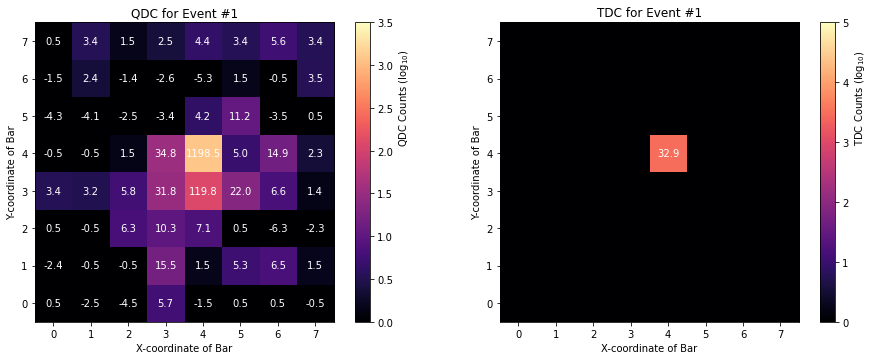

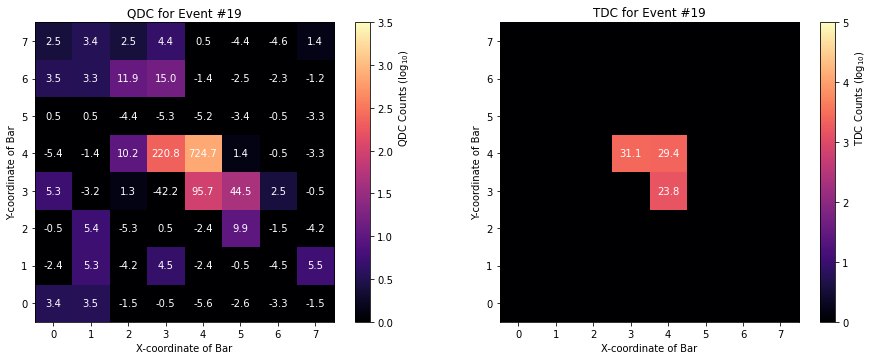

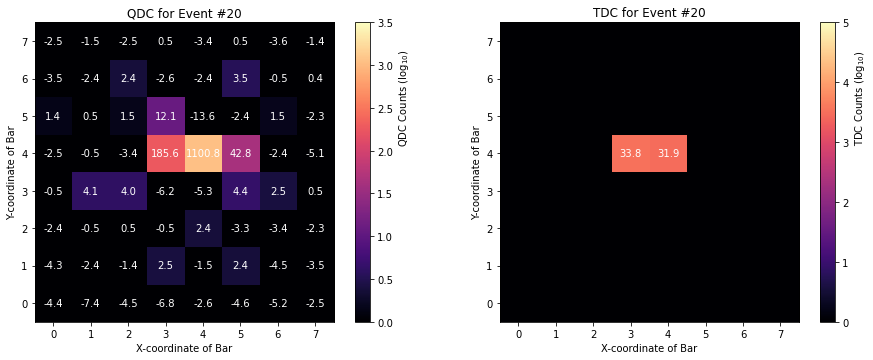

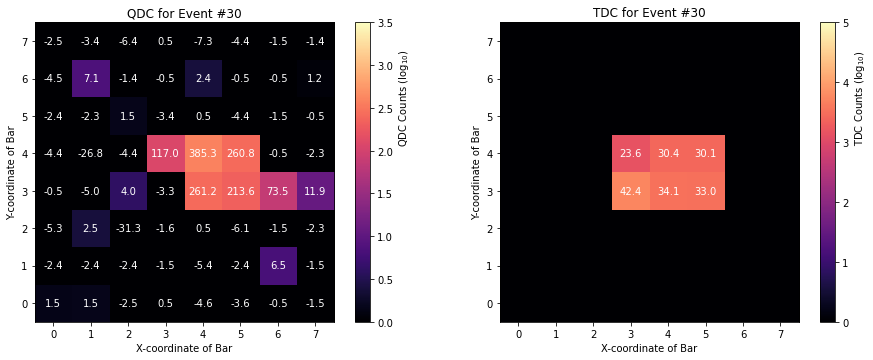

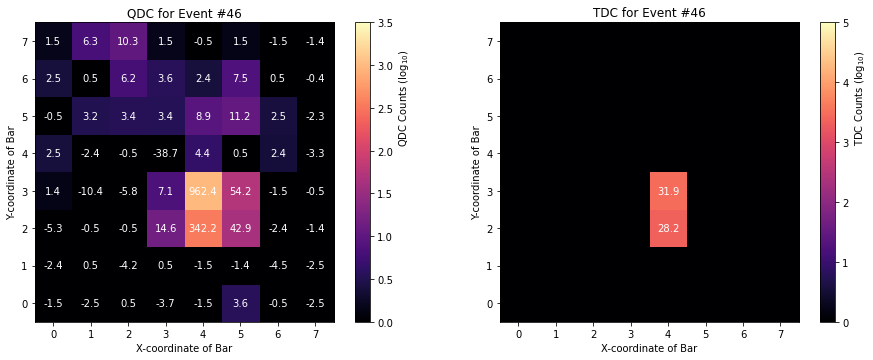

In [5]:
# quick inspect events

# targets = [741822,5,7,22184,88965,1768,2935,3219,3944,4394,4548,7070]

# for target in targets:
#     event_num = np.where(raw_data[2]==target)[0][0]
#     plotEvent(raw_data, event_num)

for event_num in range(5):
    plotEvent(raw_data, event_num)

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `ogEventNums`: An array where `ogEventNums[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events## 2.1. Helper Functions

---
# 2. Compare Esums

## 2.1. Helper Functions

In [6]:
def Esum1(raw_data, event_num, showStats=False, showEvent=False):
    '''
    Takes an 8x8 array of QDC values, finds the maximum value, and returns the sum of the max value + 8 surrounding values
    '''
    
    # Initial values/params
    _, QDC, ogEventNums = raw_data[:]
    frame = QDC[event_num]
    
    maxVal = np.amax(frame)
    maxPos = np.where(maxVal == frame)
    max_x = maxPos[0][0]
    max_y = maxPos[1][0]
    
    # Sum surrounding 8 voxels
    
    Esum = 0
    threshold = 0 # QDC values above this threshold will be added to the total Esum
    
    maxVal2 = 0
    E_total = 0
    
    for x in range(8):
        for y in range(8):
            if frame[x][y] >= threshold:
                E_total += frame[x][y]
            
            if abs(x-max_x) <= 1 and abs(y-max_y) <= 1 and frame[x][y] >= threshold:
                Esum += frame[x][y]
                
                if (x,y)!=(max_x,max_y) and frame[x][y] > maxVal2:
                    maxVal2 = frame[x][y]
                
    # Verbose output
    
    # avoid using this, it conflicts with showEvent functionality of esum2
    if showEvent: 
        plotEvent(raw_data,event_num)
        
    if showStats:
        print()
        print('******')
        print(f'{Esum:.2f}            = Energy sum (sum nonzero QDC values in max bar + 8 surrounding.')
        print('******')
        print()
        print(f'{maxVal:.2f} @ ({max_x},{max_y})    = Max QDC value @ (bar coordinate).')
        print()
        print(f'{maxVal / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar.')
        print(f'{(maxVal+maxVal2) / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar + 2nd highest QDC bar.')
        print(f'{Esum / E_total * 100:.2f}%            = Percent of total energy captured by energy sum.')
        print()
        print(f'Event #{ogEventNums[event_num]} (index {event_num})')

    
        # print(f'Sum of nonzero QDC values in 8 bars surrounding max bar          {Esum:.2f}')
        # print(f'Max QDC value and coordinate of bar                              {maxVal:.2f} @ ({max_x},{max_y})')
        # print(f'%Energy sum captured by central bar                              {maxVal / Esum * 100:.2f}%')
        # print(f'%Energy sum captured by central bar + 2nd highest QDC bar        {(maxVal+maxVal2) / Esum * 100:.2f}%.')
    
    return Esum #, [max_x, max_y]


def Esum1_forall(raw_data):
    # preallocate
    num_events = np.shape(raw_data[0]) [0]
    all_Esums = np.zeros(num_events, dtype=float)

    # calc values
    for event_num in range(num_events):
        all_Esums[event_num] = Esum1(raw_data, event_num)
        
    return all_Esums


################################################################################################################################################

def Esum2(raw_data, event_num, showStats=False, showHits=False):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Finds the total energy deposited by the scattering event by summing outliers, then subtracting the average non-outlier and subtracting it as noise
    '''
    
    _, QDC, ogEventNums = raw_data[:]
    
    ## 1. Find outliers and add to Esum
    frame = QDC[event_num]
    # frame = np.where(raw_data[1][event_num] < 0, 0, raw_data[1][event_num]) # If you replace negative values with 0, you tend to capture more voxels. Not sure if this is a good thing.
    
    q3, q1 = np.percentile(frame, [75, 25])
    iqr = q3 - q1
    outliers = np.where(frame > q3+1.5*iqr, True, False)
    
    Esum_noisy = np.sum(frame[outliers])
    
    ## 2. Find and subtract noise
    frame_zeroed = np.where(QDC[event_num] < 0, 0, QDC[event_num])
    avgNoise = np.average(frame_zeroed[np.invert(outliers)])
    
    numHits = np.sum(outliers)
    
    Esum = Esum_noisy - avgNoise * numHits

    # if Esum_noisy < 10:
    #     Esum_noisy, Esum = 0, 0
    
    
    # Verbose output
        
    if showStats:
        print()
        print('******')        
        print(f'{Esum:.2f}            = Energy sum (sum QDC values for \"hit\" bars)')
        print('******')
        print()
        print(f'{Esum_noisy:.2f}            = Noise corrected energy sum (subtract avg QDC of non-hit bars for each hit bar)')
        print()
        print(f'{ (Esum_noisy-Esum) / Esum:.2f}%             = Percent noise adjustment.')
        print(f'{Esum / (np.sum(frame_zeroed)) * 100:.2f}%            = Percent of total energy captured by energy sum.')
        print()
        print(f'Event #{ogEventNums[event_num]} (index {event_num})')

        
    if showHits:
        fig, ax = plt.subplots(figsize=(12,4.5))
        ax.imshow(outliers.T, 'magma')
        ax.invert_yaxis()
        ax.set_title(f'QDC \"Hits\" for Event #{ogEventNums[event_num]}')
        ax.set_xlabel('X-coordinate of Bar')
        ax.set_ylabel('Y-coordinate of Bar')
        plt.show()

        

    return Esum, Esum_noisy


def Esum2_forall(raw_data):
    # preallocate
    num_events = np.shape(raw_data[0]) [0]
    all_Esums = np.zeros(num_events, dtype=float)

    # calc values
    for event_num in range(num_events):
        all_Esums[event_num] = Esum2(raw_data, event_num)[0] # 0 for noise corrected, 1 for raw
        
    return all_Esums



################################################################################################################################################



def removeDoubleHits(raw_data, TDC_threshold=1.0):
    TDC_cut = []
    QDC_cut = []
    ogEventNum_cut = []
    
    TDC, QDC, ogEventNum = raw_data[:]
    total_num_events = np.shape(TDC)[0]
    num_double_events = 0

    for event_num in range(total_num_events):
        frame = TDC[event_num]

        maxVal = np.amax(frame)

        minVal = 0
        for x in range(8):
            for y in range(8):
                if frame[x][y] > minVal and frame[x][y] != maxVal:
                    minVal = frame[x][y]

        if maxVal - minVal > TDC_threshold and minVal > 1: # if this event has two hits
            num_double_events += 1
        else:
            TDC_cut.append(TDC[event_num])
            QDC_cut.append(QDC[event_num])
            ogEventNum_cut.append(ogEventNum[event_num])
    
    return [TDC_cut,QDC_cut,ogEventNum_cut]

Test output:

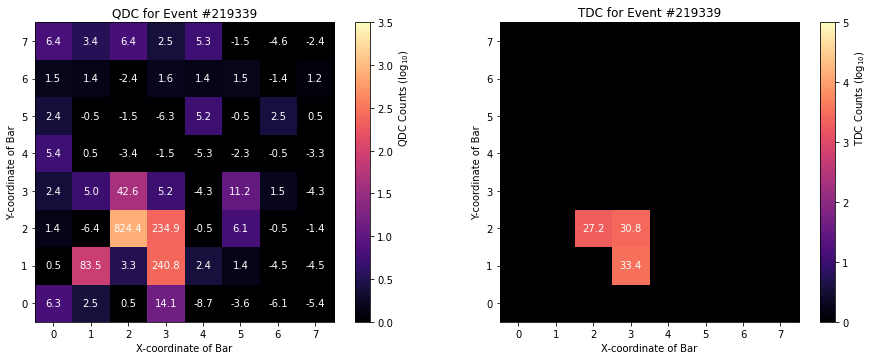


******
1439.70            = Energy sum (sum nonzero QDC values in max bar + 8 surrounding.
******

824.38 @ (2,2)    = Max QDC value @ (bar coordinate).

57.26%            = Percent of energy sum deposited into central bar.
73.98%            = Percent of energy sum deposited into central bar + 2nd highest QDC bar.
93.53%            = Percent of total energy captured by energy sum.

Event #219339 (index 10011)

----------------------------------------------


******
1430.06            = Energy sum (sum QDC values for "hit" bars)
******

1440.30            = Noise corrected energy sum (subtract avg QDC of non-hit bars for each hit bar)

0.01%             = Percent noise adjustment.
92.91%            = Percent of total energy captured by energy sum.

Event #219339 (index 10011)


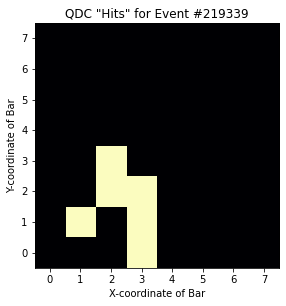

In [7]:
event_num=10011
plotEvent(raw_data,event_num)

_ = Esum1(raw_data,event_num,showStats=True)
print()
print('----------------------------------------------')
print()
_ = Esum2(raw_data,event_num,showHits=True,showStats=True)

## 2.2. Process Calo Data
- For all events, with and without double events
- For both energy summing methods

In [8]:
# Calculate energy sums on raw data

t0 = time.time()
Esum1_all = Esum1_forall(raw_data)
t1 = time.time()
print(f"Esum1 uncut took {t1-t0:.2f} seconds.")

t0 = time.time()
Esum2_all = Esum2_forall(raw_data)
t1 = time.time()
print(f"Esum2 uncut took {t1-t0:.2f} seconds.")

Esum1 uncut took 1.86 seconds.
Esum2 uncut took 5.27 seconds.


In [9]:
# Remove double hits from data

t0 = time.time()

cut_data = removeDoubleHits(raw_data)

t1 = time.time()
print(f"Removing double hits took {t1-t0:.2f} seconds.")

Removing double hits took 0.72 seconds.


In [10]:
# Calculate energy sums on cut data

t0 = time.time()
Esum1_all_cut = Esum1_forall(cut_data)
t1 = time.time()
print(f"Esum1 cut took {t1-t0:.2f} seconds.")

t0 = time.time()
Esum2_all_cut = Esum2_forall(cut_data)
t1 = time.time()
print(f"Esum2 cut took {t1-t0:.2f} seconds.")

Esum1 cut took 0.82 seconds.
Esum2 cut took 2.33 seconds.


## 2.3. Compare 4 Calo datasets

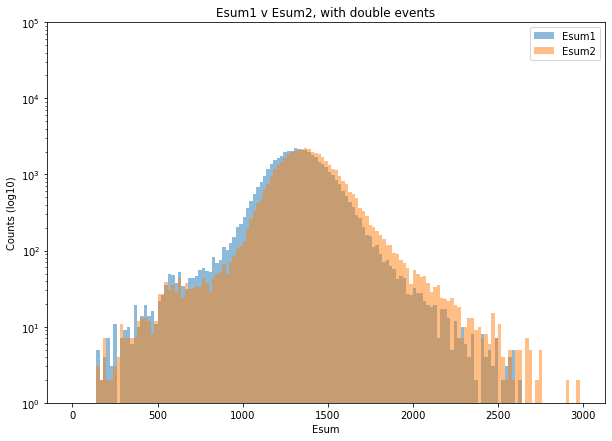

In [11]:
## esum1 vs esum2

fig, axs = plt.subplots(figsize=(10,7))

xmin=0
xmax=3000
xstep=20
ymin=1
ymax=10**5

axs.hist(Esum1_all, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='Esum1')
axs.hist(Esum2_all, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='Esum2')


axs.set_yscale('log')
axs.set_ylim(ymin,ymax)
axs.set_title('Esum1 v Esum2, with double events')
axs.set_xlabel('Esum')
axs.set_ylabel('Counts (log10)')
axs.legend(loc='upper right')

plt.show()

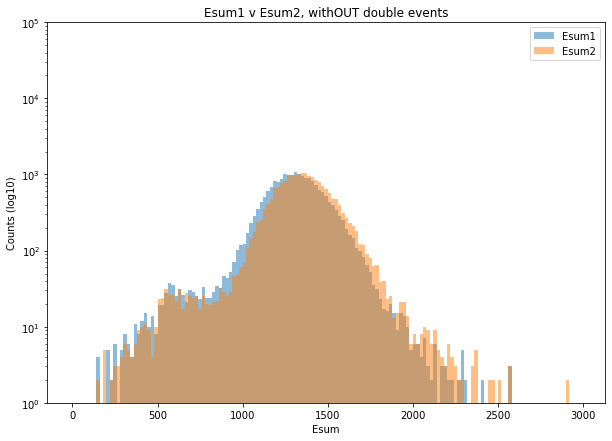

In [12]:
## esum1 vs esum2

fig, axs = plt.subplots(figsize=(10,7))

# xmin=0
# xmax=1750
# xstep=20
# ymin=1
# ymax=10**5

axs.hist(Esum1_all_cut, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='Esum1')
axs.hist(Esum2_all_cut, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='Esum2')


axs.set_yscale('log')
axs.set_ylim(ymin,ymax)
axs.set_title('Esum1 v Esum2, withOUT double events')
axs.set_xlabel('Esum')
axs.set_ylabel('Counts (log10)')
axs.legend(loc='upper right')

plt.show()

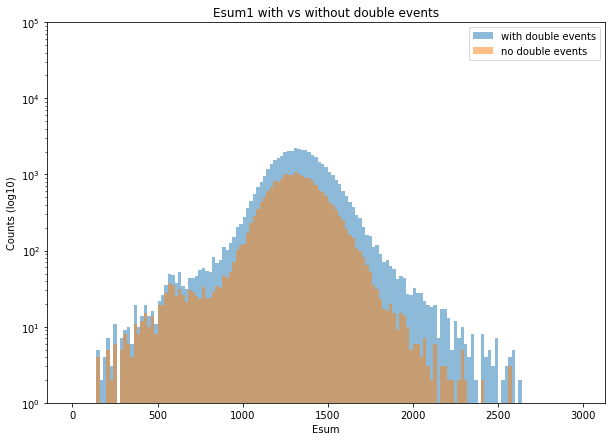

In [13]:
# with vs without double events

fig, axs = plt.subplots(figsize=(10,7))

# xmin=0
# xmax=1750
# xstep=20
# ymin=1
# ymax=10**5

axs.hist(Esum1_all, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='with double events')
axs.hist(Esum1_all_cut, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='no double events')


axs.set_yscale('log')
axs.set_ylim(ymin,ymax)
axs.set_title('Esum1 with vs without double events')
axs.set_xlabel('Esum')
axs.set_ylabel('Counts (log10)')
axs.legend(loc='upper right')

plt.show()

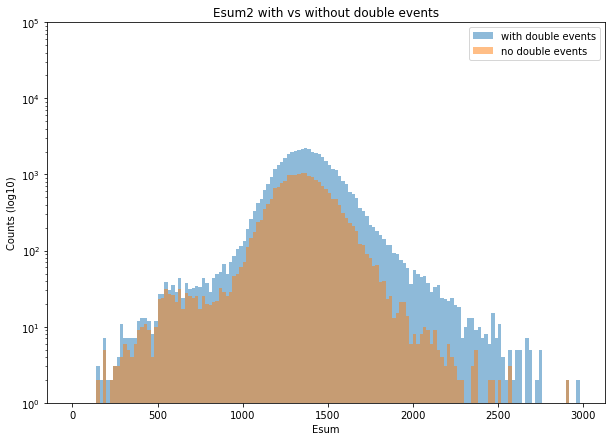

In [14]:
# with vs without double events

fig, axs = plt.subplots(figsize=(10,7))

# xmin=0
# xmax=1750
# xstep=20
# ymin=1
# ymax=10**5

axs.hist(Esum2_all, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='with double events')
axs.hist(Esum2_all_cut, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='no double events')


axs.set_yscale('log')
axs.set_ylim(ymin,ymax)
axs.set_title('Esum2 with vs without double events')
axs.set_xlabel('Esum')
axs.set_ylabel('Counts (log10)')
axs.legend(loc='upper right')

plt.show()

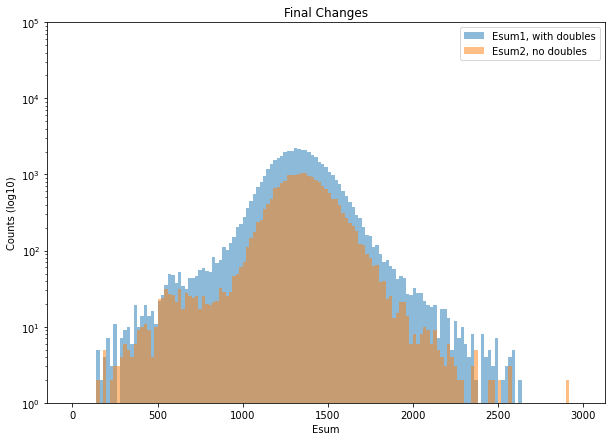

In [15]:
# esum1 w doubles vs esum2 w/out doubles

## esum1 vs esum2

fig, axs = plt.subplots(figsize=(10,7))

# xmin=0
# xmax=1750
# xstep=20
# ymin=1
# ymax=10**5

axs.hist(Esum1_all, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='Esum1, with doubles')
axs.hist(Esum2_all_cut, 
            alpha=0.5, 
            bins=range(xmin, xmax, xstep), 
            label='Esum2, no doubles')


axs.set_yscale('log')
axs.set_ylim(ymin,ymax)
axs.set_title('Final Changes')
axs.set_xlabel('Esum')
axs.set_ylabel('Counts (log10)')
axs.legend(loc='upper right')

plt.show()

In [16]:
x = (len(raw_data[0])-len(cut_data[0]))/len(raw_data[0])
print(f'Percent of double events in this dataset = {100*x:.2f}%')

Percent of double events in this dataset = 53.97%


---
# Misc

## Take a random sample of what I'm considering "double hits"

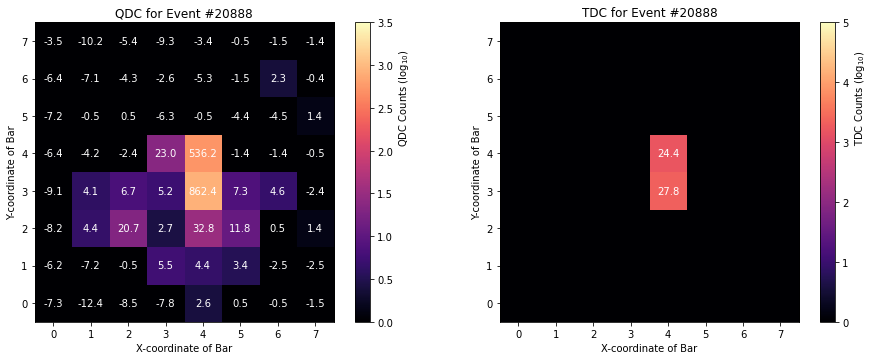

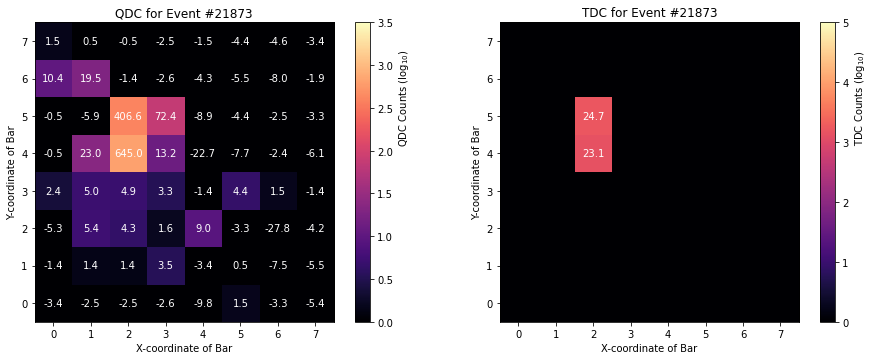

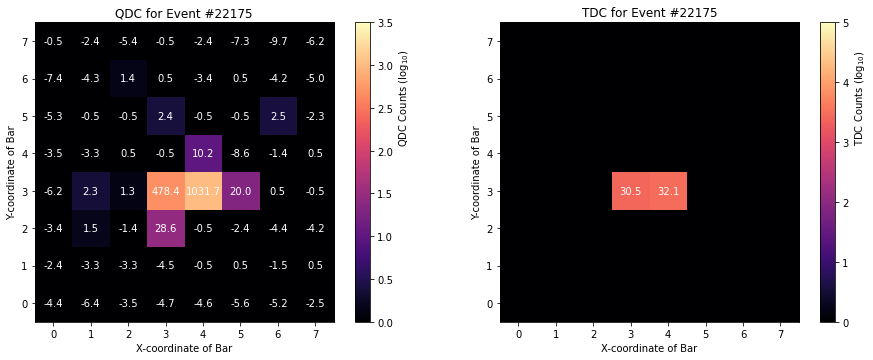

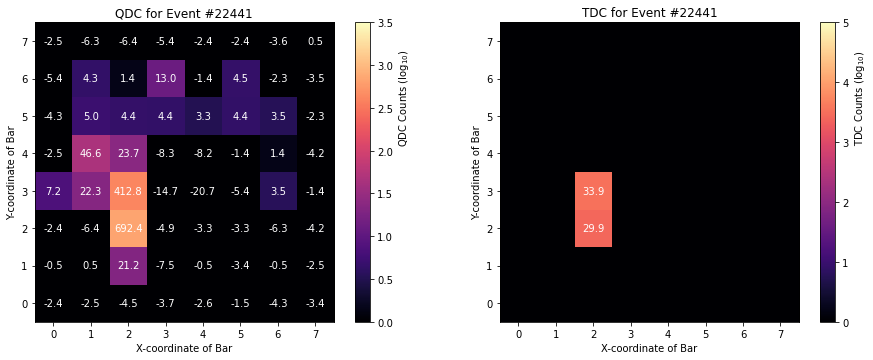

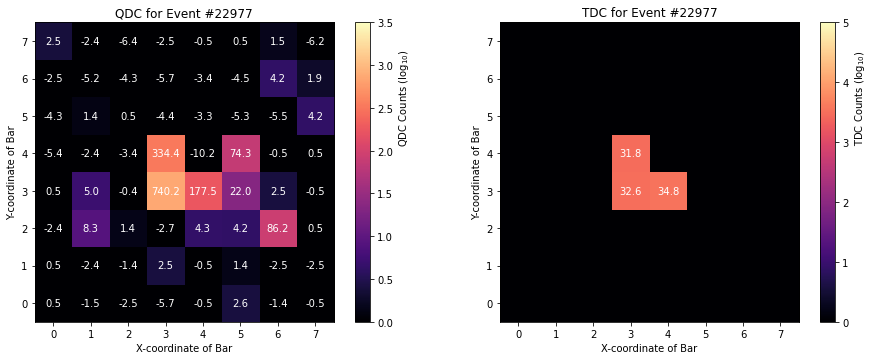

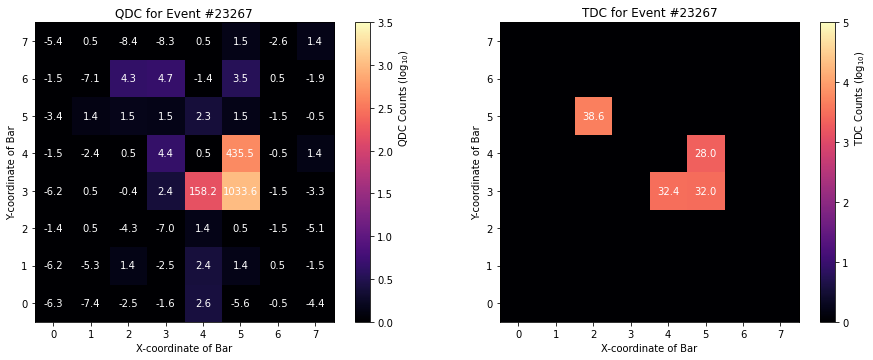

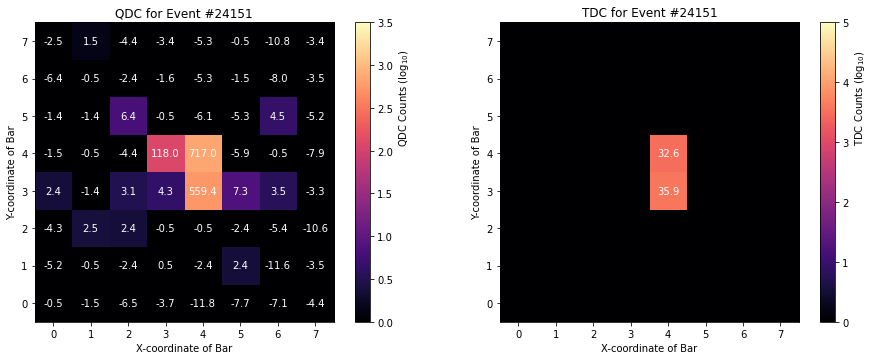

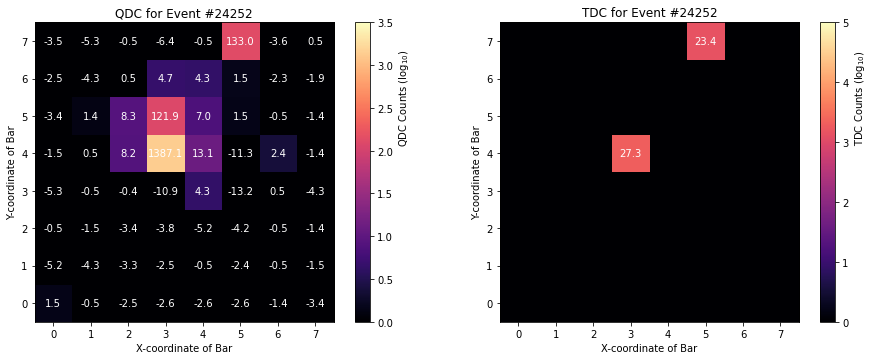

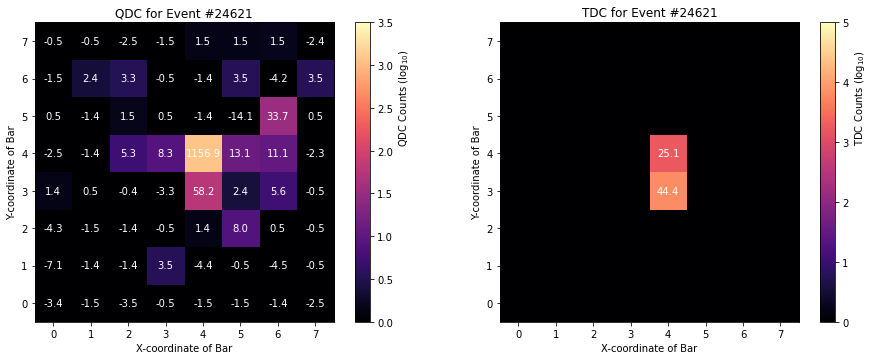

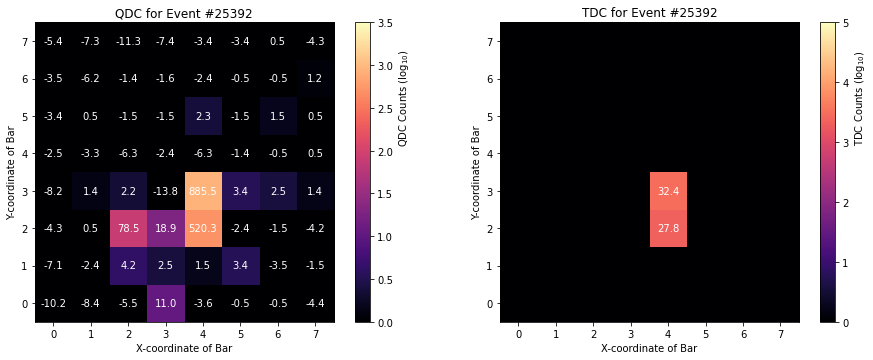

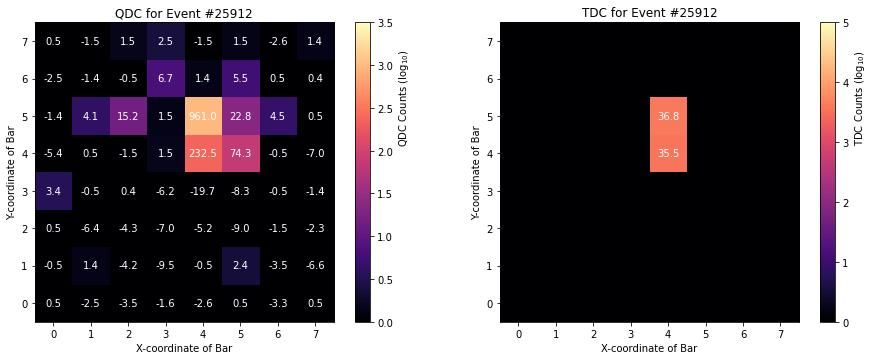

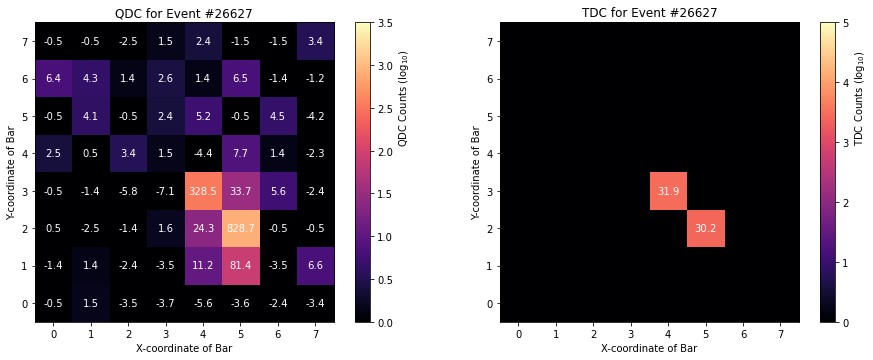

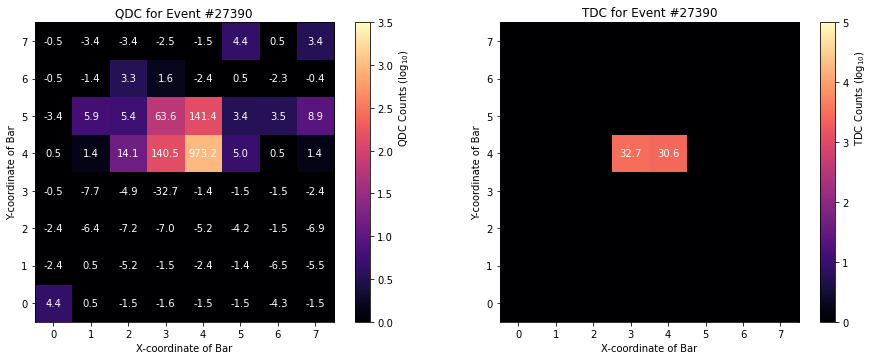

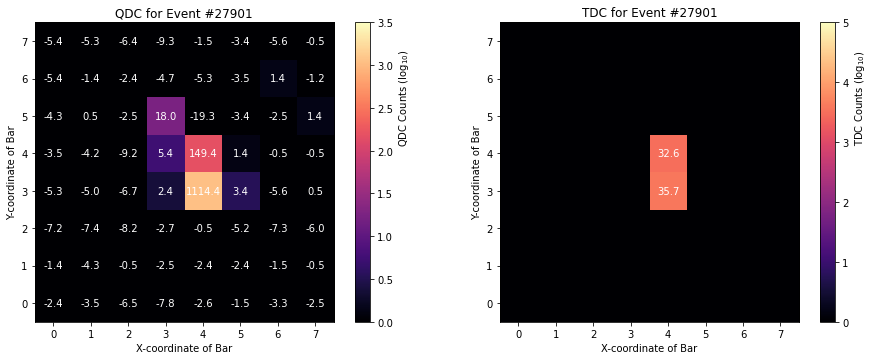

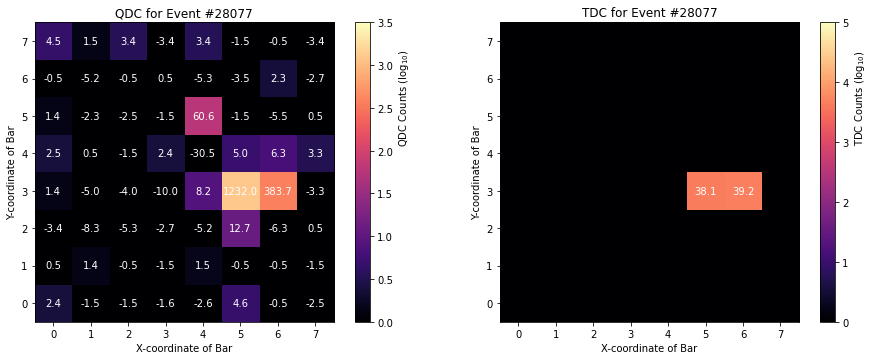

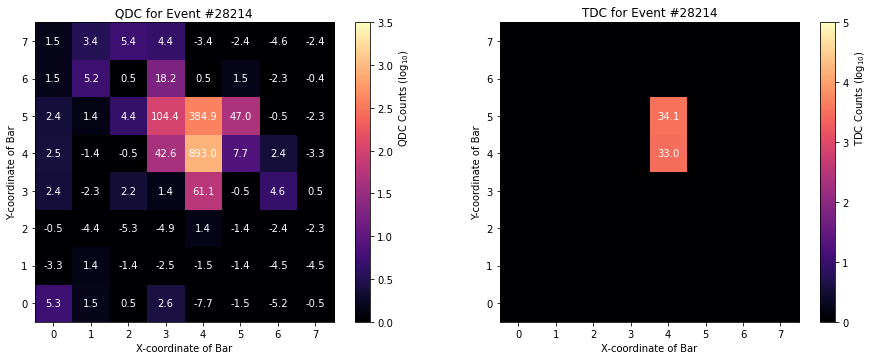

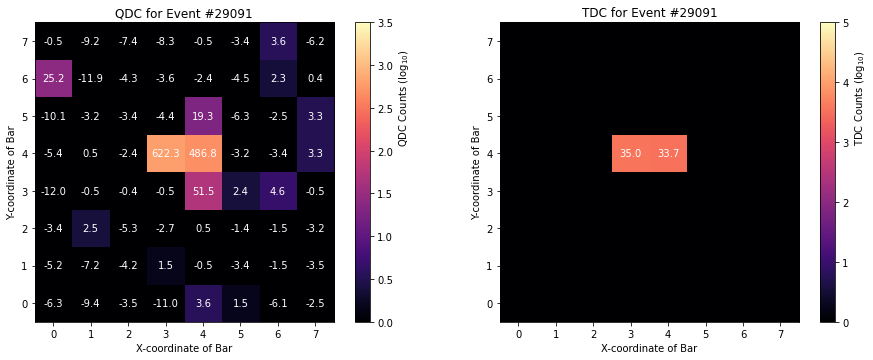

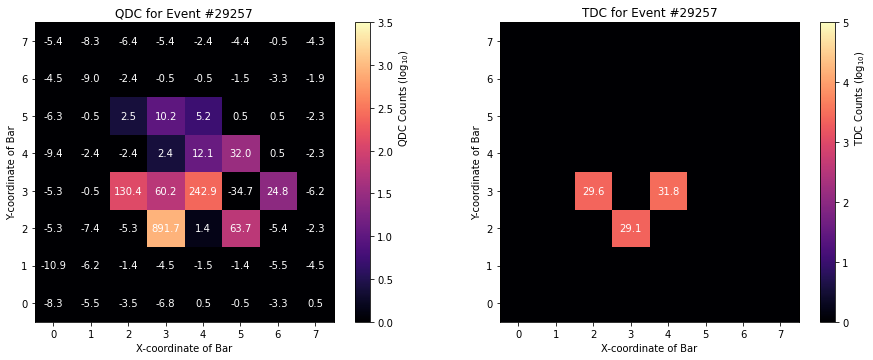

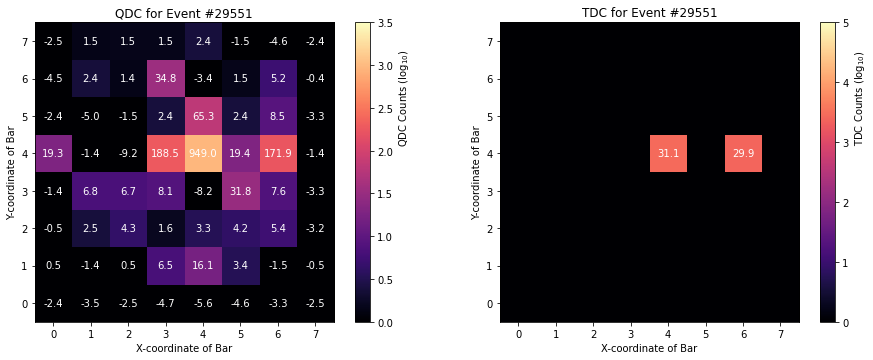

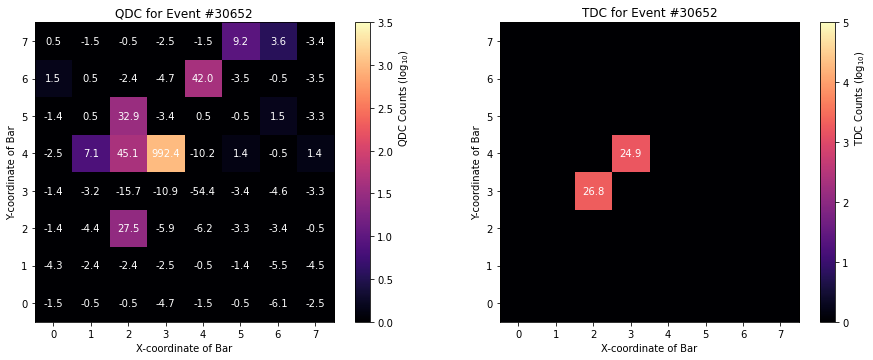

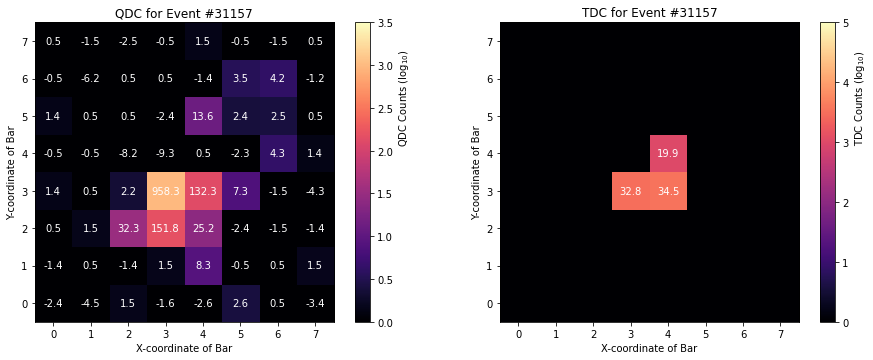

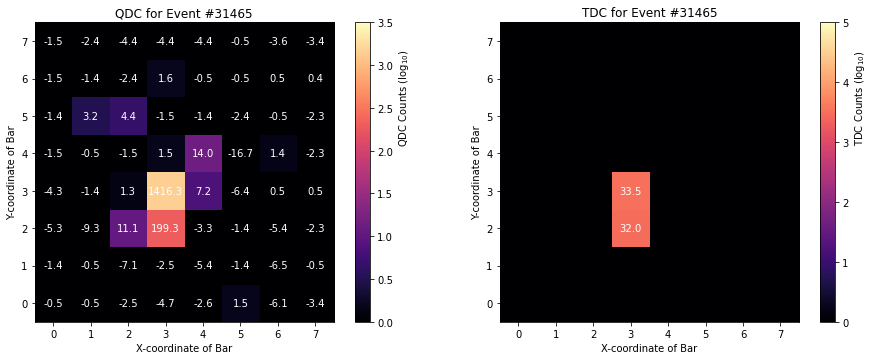

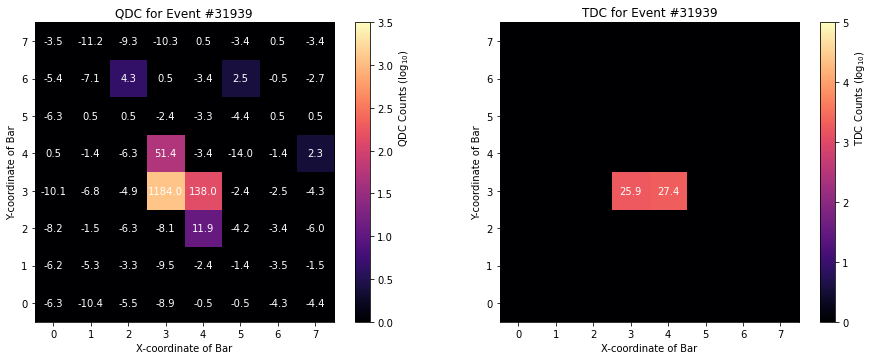

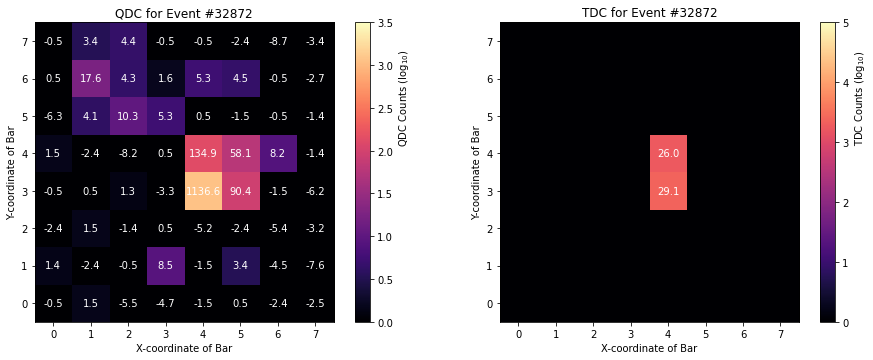

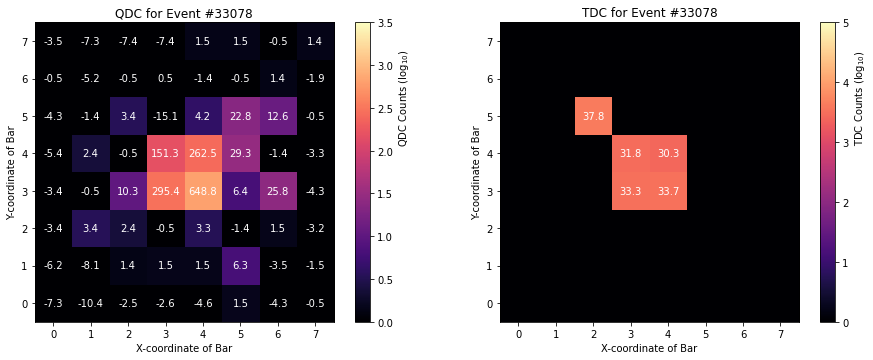

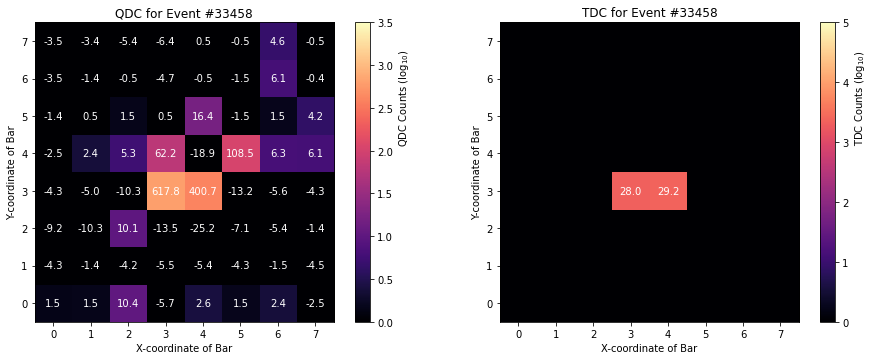

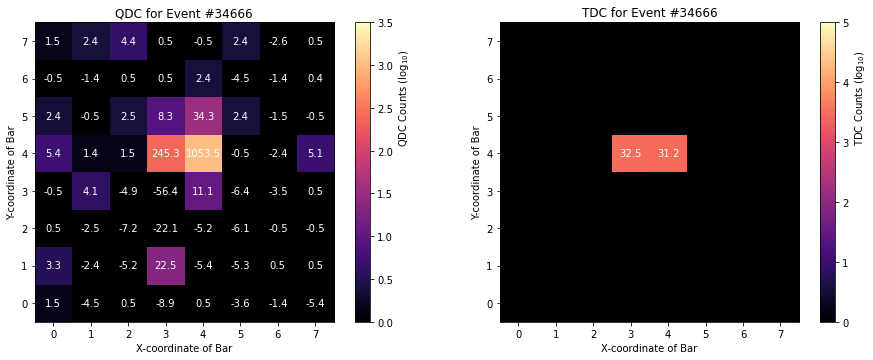

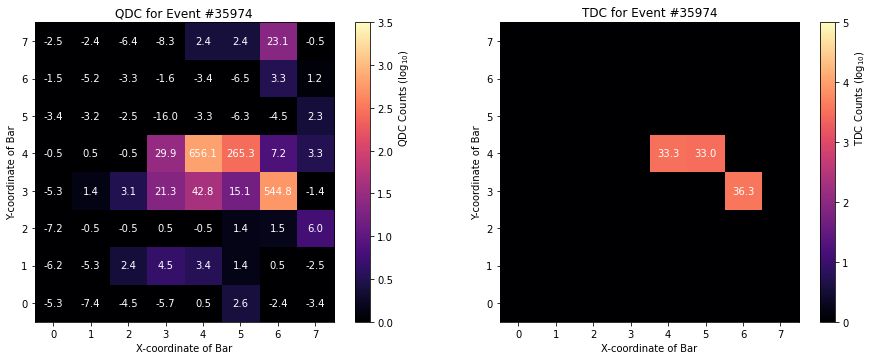

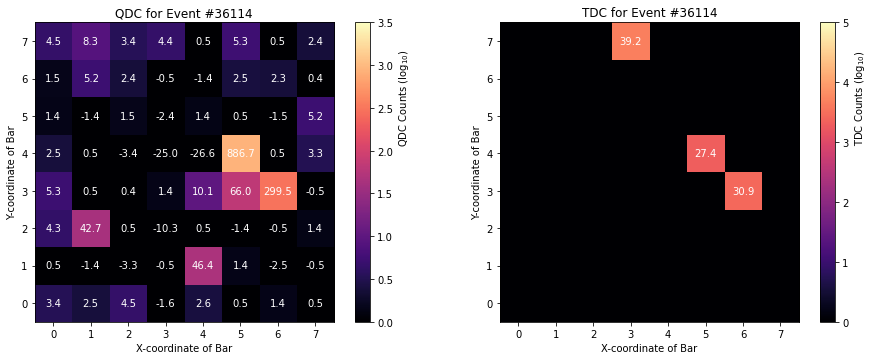

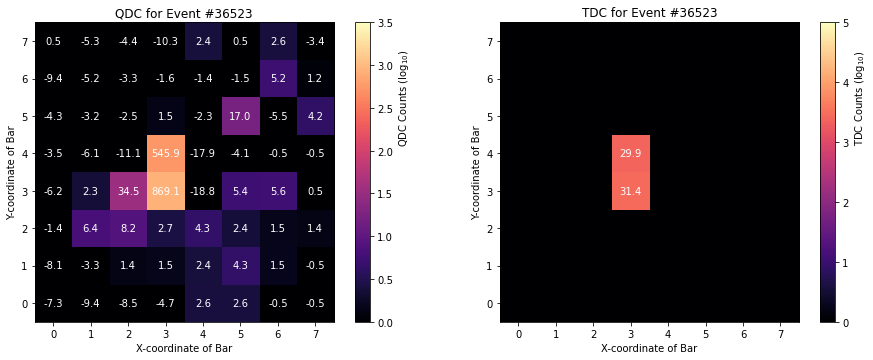

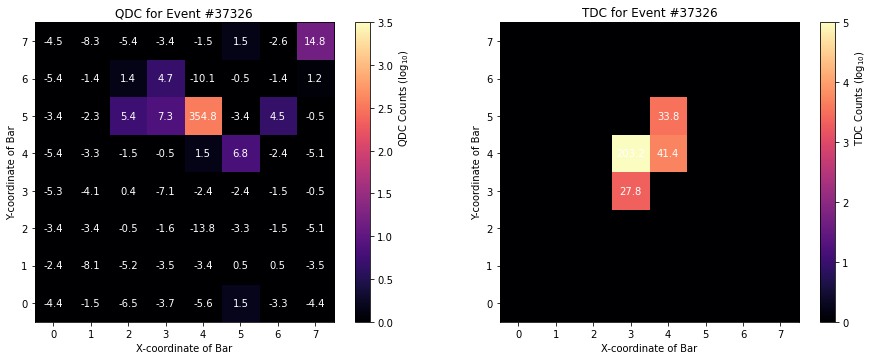

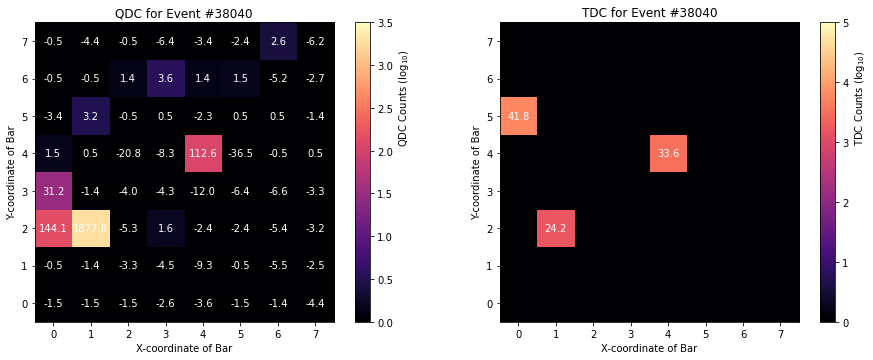

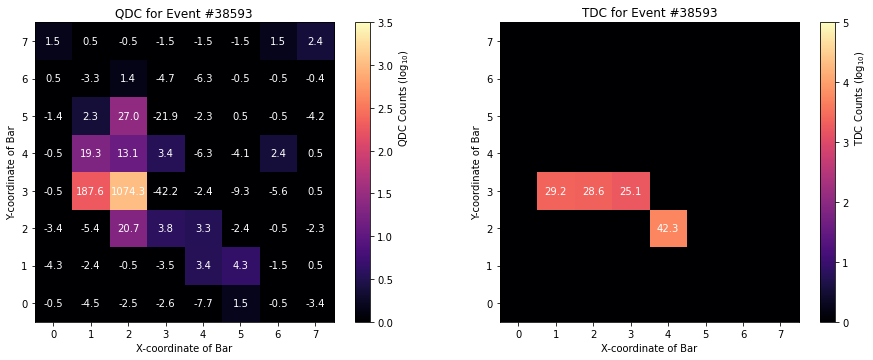

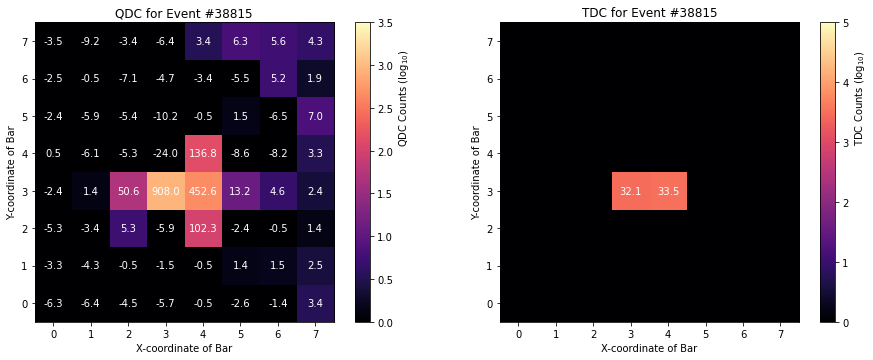

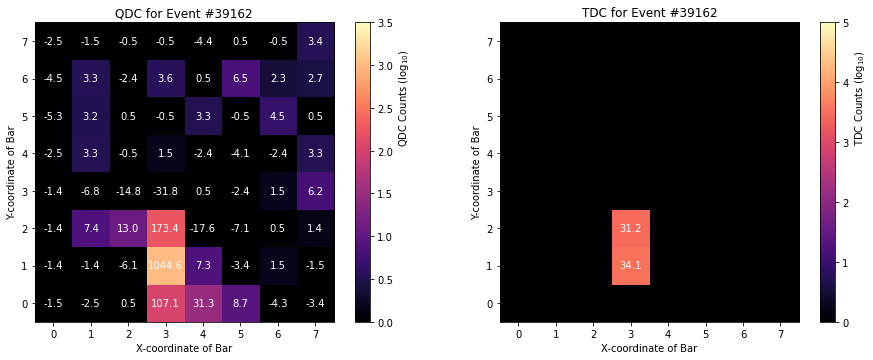

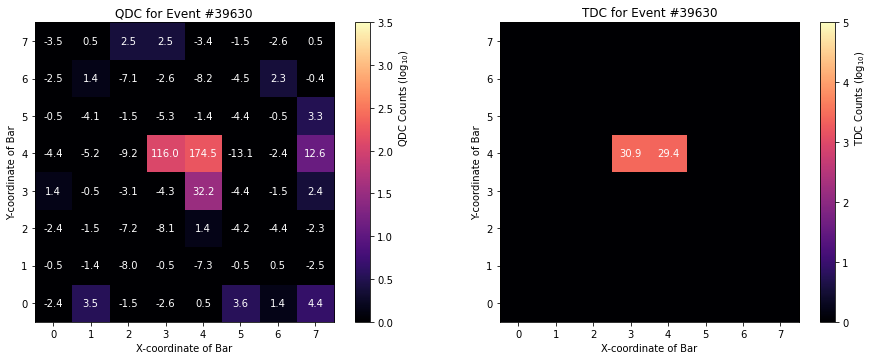

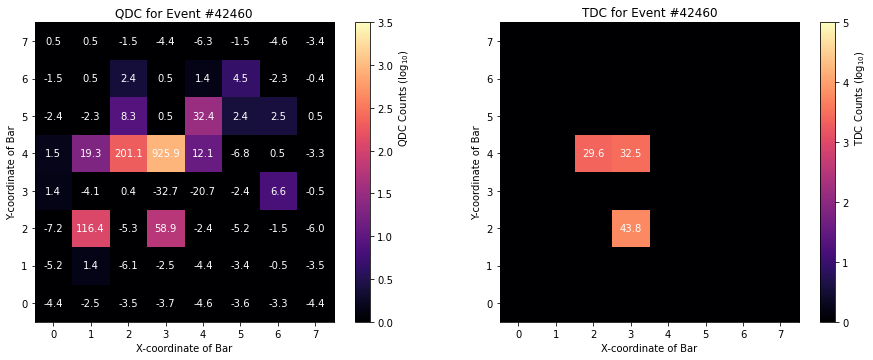

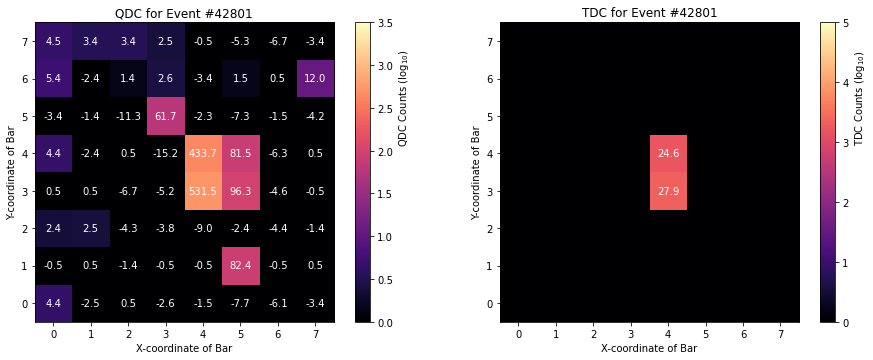

In [17]:
for i in range(1000,2000,10):
    if raw_data[2][i] not in cut_data[2]:
        plotEvent(raw_data, i)